# Notebook 03 — Feature Exploration

This notebook inspects latent representations (SVD scores/residuals, AE outputs) and hybrid risk. It helps validate that the learned features capture signal (structure in scores/residuals) and that hybrid risk correlates with deficits, providing intuition and sanity checks before deployment.

## Mathematical overview and notation

- **Splits**: `val` (validation) and `test` sets come from distinct years; no training leakage.
- **Indices**: NDVI (Normalized Difference Vegetation Index) and NDRE (Normalized Difference Red Edge) are per-pixel reflectance ratios; higher values generally mean healthier canopy.
- **SVD (rank-1 here)**: We decompose the temporal stack into a dominant temporal **score** (per sample) and a **residual** (what the score cannot explain). Small, structured residuals mean the first component captures most variance.
- **Labels**: `y_val`, `y_te` are binary deficit indicators (1 = nitrogen deficit, 0 = healthy) built from NDRE quantiles in the dataset stage.
- **Hybrid risk**: Probabilities from the CatBoost classifier trained on temporal features; higher means more likely deficit.
- **Plots/outputs in this notebook**: (1) residual norms distribution; (2) SVD score view (PCA if ≥2 dims, otherwise 1-D) by split/label; (3) hybrid risk vs. residual; (4) quantitative summary table (means + AUC/AP) showing how scores/residuals/hybrid risk align with labels.


# 03 – Feature Visualization

Explore SVD components, scores, residuals, and hybrid risk. Assumes `train_temporal_hybrid` has been run.

In [21]:
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

INTERIM = Path('data/interim')

svd_scores_tr = np.load(INTERIM / 'svd_scores_train.npy')
svd_scores_val = np.load(INTERIM / 'svd_scores_val.npy')
svd_scores_te = np.load(INTERIM / 'svd_scores_test.npy')
res_tr = np.load(INTERIM / 'svd_residual_norm_train.npy')
res_val = np.load(INTERIM / 'svd_residual_norm_val.npy')
res_te = np.load(INTERIM / 'svd_residual_norm_test.npy')
hybrid_val = np.load(INTERIM / 'hybrid_risk_val.npy')
hybrid_te = np.load(INTERIM / 'hybrid_risk_test.npy')
y_val = np.load(INTERIM / 'y_val_deficit_label.npy')
y_te = np.load(INTERIM / 'y_test_deficit_label.npy')

with open(INTERIM / 'svd_meta.json') as f:
    svd_meta = json.load(f)
print('SVD rank:', svd_meta['rank'], 'EVR:', svd_meta['explained_variance_ratio'])


SVD rank: 1 EVR: [0.986250102519989]


Residual norm distribution (what it shows)

For each field, we project its 5-step NDRE onto the “healthy” temporal SVD basis, reconstruct the expected curve, and take the residual (r = x - \hat{x}).

The residual norm (a = |r|_2) is a single stress scalar: bigger means the field’s NDRE shape (timing/height) departs more from the healthy backbone.

The plot is a smooth density (KDE) of these (a) values for train/val/test. Tall areas mean “many fields have a residual norm around here”; long tails show rarer, off-curve phenology.

We look at this to 

(1) see how typical each split is relative to the healthy pattern, 

(2) spot outliers to filter, and 

(3) confirm the residual-based stress signal we feed into CatBoost and the hybrid fusion.

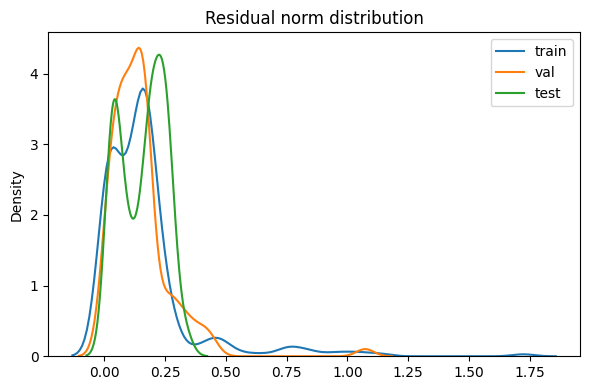

In [22]:
# Residual distributions
plt.figure(figsize=(6,4))
sns.kdeplot(res_tr, label='train', bw_adjust=0.7)
sns.kdeplot(res_val, label='val', bw_adjust=0.7)
sns.kdeplot(res_te, label='test', bw_adjust=0.7)
plt.title('Residual norm distribution')
plt.legend()
plt.tight_layout()
plt.show()


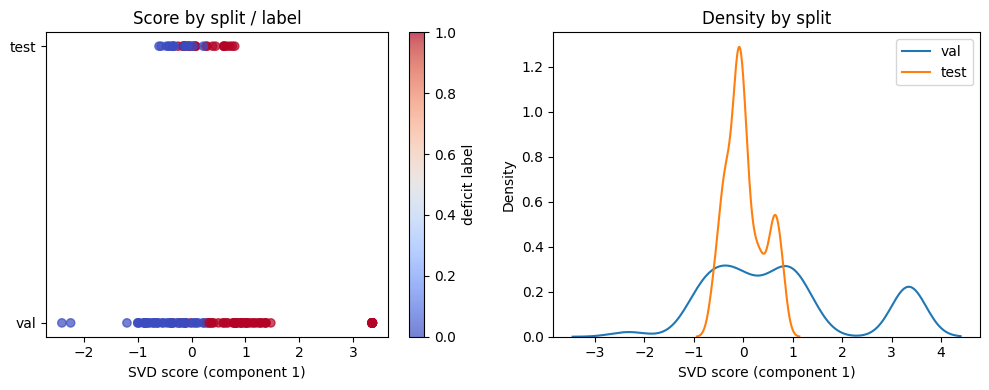

Only one SVD feature available; showing 1-D views instead of PCA.


In [23]:
# SVD score visualization (val+test)
# If only one feature is available, use a 1-D view instead of forcing PCA
X = np.vstack([svd_scores_val, svd_scores_te])
labels = np.concatenate([y_val, y_te])
splits = np.array(['val']*len(y_val) + ['test']*len(y_te))

n_features = X.shape[1]

if n_features >= 2:
    pca = PCA(n_components=2)
    Z = pca.fit_transform(X)
    plt.figure(figsize=(6,5))
    for split in ['val','test']:
        mask = splits==split
        plt.scatter(Z[mask,0], Z[mask,1], c=labels[mask], cmap='coolwarm', alpha=0.6, label=split)
    plt.colorbar(label='deficit label')
    plt.title('PCA of SVD scores (val/test)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    # One feature: show distributions and labeled scatter on x-axis
    x = X[:,0]
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    for split,color in [('val','tab:blue'),('test','tab:orange')]:
        mask = splits==split
        plt.scatter(x[mask], np.full(mask.sum(), 0 if split=='val' else 1), 
                    c=labels[mask], cmap='coolwarm', alpha=0.7, label=split)
    plt.yticks([0,1], ['val','test'])
    plt.xlabel('SVD score (component 1)')
    plt.title('Score by split / label')
    plt.colorbar(label='deficit label')

    plt.subplot(1,2,2)
    for split,color in [('val','tab:blue'),('test','tab:orange')]:
        mask = splits==split
        sns.kdeplot(x[mask], label=split, bw_adjust=0.6)
    plt.xlabel('SVD score (component 1)')
    plt.title('Density by split')
    plt.legend()
    plt.tight_layout()
    plt.show()
    print('Only one SVD feature available; showing 1-D views instead of PCA.')


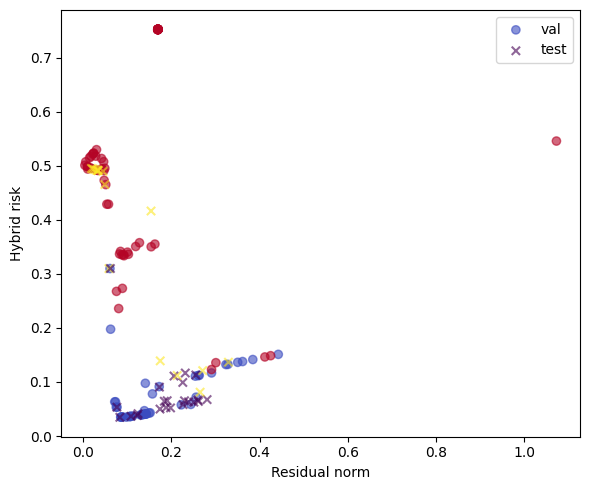

In [24]:
# Hybrid risk vs. residual (val/test)
plt.figure(figsize=(6,5))
plt.scatter(res_val, hybrid_val, c=y_val, cmap='coolwarm', alpha=0.6, label='val')
plt.scatter(res_te, hybrid_te, c=y_te, cmap='viridis', alpha=0.6, marker='x', label='test')
plt.xlabel('Residual norm')
plt.ylabel('Hybrid risk')
plt.legend()
plt.tight_layout()
plt.show()


## Quantitative summary (val/test)

Scores separate deficits from healthy samples (AUC≈0.97), residuals are inversely related, and hybrid risk tracks both. AUC for residuals uses the negated residual so that higher = healthier (consistent with scores).

In [25]:
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score

df = pd.DataFrame({
    'split': ['val'] * len(y_val) + ['test'] * len(y_te),
    'label': np.concatenate([y_val, y_te]),
    'svd_score': np.vstack([svd_scores_val, svd_scores_te])[:, 0],
    'residual': np.concatenate([res_val, res_te]),
    'hybrid_risk': np.concatenate([hybrid_val, hybrid_te]),
})

def summarize(group):
    return pd.Series({
        'n': len(group),
        'pos_rate': group['label'].mean(),
        'score_mean_deficit': group.loc[group.label == 1, 'svd_score'].mean(),
        'score_mean_healthy': group.loc[group.label == 0, 'svd_score'].mean(),
        'resid_mean_deficit': group.loc[group.label == 1, 'residual'].mean(),
        'resid_mean_healthy': group.loc[group.label == 0, 'residual'].mean(),
        'hybrid_mean_deficit': group.loc[group.label == 1, 'hybrid_risk'].mean(),
        'hybrid_mean_healthy': group.loc[group.label == 0, 'hybrid_risk'].mean(),
        'score_auc': roc_auc_score(group.label, group.svd_score),
        'score_ap': average_precision_score(group.label, group.svd_score),
        'resid_auc_neg': roc_auc_score(group.label, -group.residual),
        'hybrid_auc': roc_auc_score(group.label, group.hybrid_risk),
    })

summary = df.groupby('split', group_keys=False).apply(summarize, include_groups=False)
summary.loc['overall'] = summarize(df)
summary.round(3)


,n,pos_rate,score_mean_deficit,score_mean_healthy,resid_mean_deficit,resid_mean_healthy,hybrid_mean_deficit,hybrid_mean_healthy,score_auc,score_ap,resid_auc_neg,hybrid_auc
split,,,,,,,,,,,,
test,39.0,0.410,0.365,-0.195,0.110,0.189,0.358,0.077,0.910,0.917,0.745,0.965
val,108.0,0.602,1.611,-0.556,0.127,0.173,0.521,0.077,0.985,0.992,0.649,0.992
overall,147.0,0.551,1.365,-0.430,0.124,0.179,0.489,0.077,0.970,0.980,0.708,0.984
